<a href="https://colab.research.google.com/github/karabhilash/CS6910-Fun_of_DL/blob/main/CS6910_Assignment1_WnB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install wandb
import wandb

     |████████████████████████████████| 1.8MB 6.7MB/s 
     |████████████████████████████████| 174kB 25.0MB/s 
     |████████████████████████████████| 102kB 8.8MB/s 
     |████████████████████████████████| 133kB 23.1MB/s 
     |████████████████████████████████| 71kB 7.1MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6502 sha256=63300f72ea990162bdd2dd57a797da007a0f4f8257a2173755894da2fc0574f5
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8807 sha256=50190b3cb86950649744f371a89a19eb80a6d7c8149b377ff7da7214e54f201e
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
Successfully built subprocess32 pathtools


In [ ]:
wandb.finish()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
from sklearn.metrics import  mean_squared_error
import tensorflow as tf
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
import scipy as sp
import time
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, log_loss, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
def passfn():
    pass
from sklearn.metrics import mean_squared_error
from scipy.special import expit

In [3]:
def softmax(x):
    Z= x-max(x)
    return np.exp(Z) / np.sum(np.exp(Z))
def relu(Z):
  x = np.divide(Z, np.max(Z.T, axis=1))
  return np.maximum(0,x)

def tanh(Z):
  return np.tanh(Z)

def sigmoid(z):
  return expit(z)

def deriv_tanh(z):
  return 1 - np.tanh(z) ** 2

def deriv_relu(z):
  return np.array([1 if z[i]>0 else 0 for i in range(len(z))]).reshape(z.shape)  
def deriv_sigmoid(z):
  sgm = sigmoid(z)
  return sgm*(1-sgm)

### Question 1 : Visualising the dataset

In [4]:
from keras.datasets import fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()


4431872/4422102 [==============================] - 0s 0us/step


In [5]:

train_images,val_images,train_labels,val_labels = train_test_split(train_images,train_labels,test_size=0.1,shuffle=False)



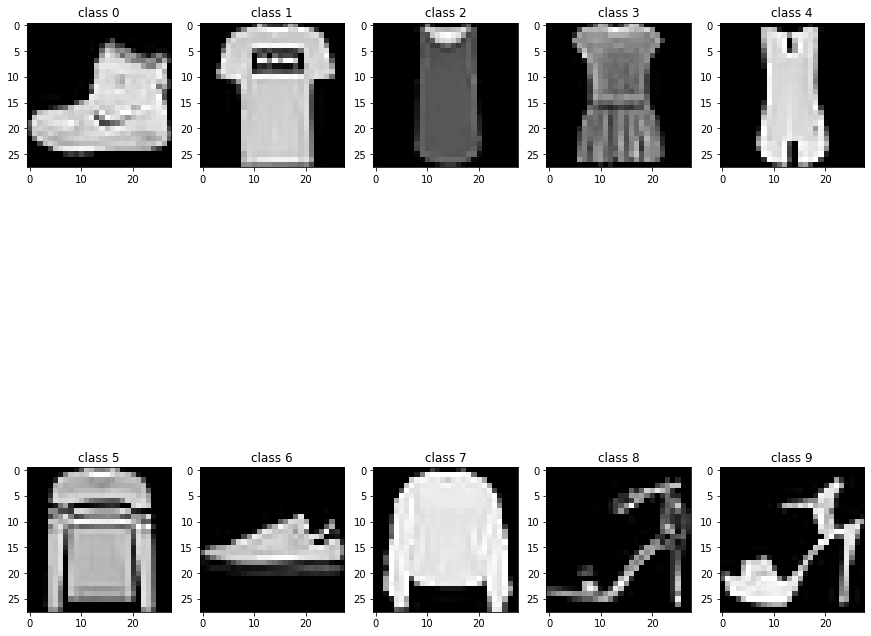

In [6]:

fig , ax =plt.subplots(2,5,figsize=(15,15))
for i in range(10):
  for j in train_labels:
    if i==j :
      ax[i//5,i%5].imshow(train_images[j],cmap='gray')
      ax[i//5,i%5].set_title("class "+str(i))
      break


In [7]:
###Initializers

def random_normal_init(size):
    return np.random.normal(size=size)

def xavier_init(size):
  xavier_stddev = np.sqrt(2 /(sum(size)))
  return np.random.normal(0,xavier_stddev,size=size)
def unisonShuffleDataset(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

### Question 2 : FeedForward Neural Network

In [8]:

class NeuralNet:
    def __init__(
        self, 
        num_layers_hidden, 
        num_neurons, 

        train_images,
        train_labels,
        val_images,
        val_labels,
        test_images,
        test_labels,

        max_epochs,
        batch_size,
        weight_decay,
        learning_rate,
        optimizer,
        activation,
        activation_deriv,
        initializer,
        loss

    ):
        self.num_layers = num_layers_hidden+2
        self.max_epoch=max_epochs
        self.batch_size = batch_size
        self.weight_decay = weight_decay
        self.learning_rate = learning_rate

        dict_opt = {"sgd":self.miniSGD, "mgd":self.MomentumGD, "nag":self.Nag, "rmsProp":self.rmsProp, "adam":self.adam,"nadam":self.nadam}
        self.optimizer = dict_opt[optimizer]
        self.activation = activation
        self.activation_deriv = activation_deriv
        self.initializer = initializer
        self.loss_function = loss

        self.neurons = num_neurons
        assert  len(self.neurons) == num_layers_hidden
        self.input_flattened_size = train_images.shape[1]*train_images.shape[2]
        self.output_layer_size = np.max(train_labels)+1

        self.layer_dims = [self.input_flattened_size] + self.neurons + [self.output_layer_size]


        self.train_images=train_images
        self.train_labels=train_labels
        self.val_images=val_images
        self.val_labels=val_labels
        self.test_images=test_images
        self.test_labels=test_labels

        self.loss = loss
        self.weights,self.biases = self.initializeWB(self.layer_dims)


    def initializeWB(self,layers):
        weights = []
        biases = []
        for i in range(len(layers)-1):
            Wi = self.initializer((layers[i+1],layers[i]))
            Bi  = np.zeros( (layers[i+1],1))
            weights+=[Wi]
            biases+=[Bi]
        return weights,biases

    def InitZero(self,layers):
        weights = []
        biases = []
        for i in range(len(layers)-1):
            Wi = np.zeros((layers[i+1],layers[i]))
            Bi  = np.zeros( (layers[i+1],1))
            weights+=[Wi]
            biases+=[Bi]
        return weights,biases


    def forward_propagation(self,input,weights,biases):
         activations = [input]
         preactivations = [input]
         x = input
         num_layers = self.num_layers
         

         for i in range(num_layers-2):
             W = weights[i]
             b  = biases[i].reshape((-1,1))
             preactivations+=[ np.add( np.matmul(W,activations[-1]) ,b)]
             activations+=[ self.activation(preactivations[-1]) ]
         W = weights[num_layers-2]
         b = biases[num_layers-2].reshape((-1,1))
         
         preactivations+= [ np.add( np.matmul(W,activations[-1]) ,b) ]
         activations+= [ softmax(preactivations[-1]) ]
         return activations[-1], activations, preactivations 

    def predict(self,input):
        pred  = []
        for i in input:
            res,_,_ = self.forward_propagation(i.reshape(self.input_flattened_size,1),self.weights,self.biases)
            pred+=[res]
        return np.array(pred)

    def back_prop(self,h,a,y):
        
        gW = {}
        gB = {}
        gA = {}
        gH = {}
        N=self.num_layers-1
        assert N+1 == len(h)
        
        gA[N] = h[N]-y   #assuming one-hot y
        for i in range(N,0,-1):
            
            gW[i]=np.matmul(gA[i],h[i-1].T)+ (self.weight_decay *  self.weights[i-1])
            gB[i]=gA[i] 
            gH[i-1]=np.matmul(self.weights[i-1].T,gA[i])
            gA[i-1] = np.multiply(gH[i-1],self.activation_deriv(a[i-1]))
        return gW,gB


    def update_wb(self,dw,db):
        for i in range(self.num_layers -1):
            self.weights[i]-= dw[i]
            self.biases[i]-= db[i]
            
    def labelize(self,dist):
        return np.argmax(dist.reshape(self.output_layer_size,1),axis=0)
    def accuracy(self,y_pred,y_train,N_train):
        c=0
        y_pre = []
        y_true = []
        for i in range(N_train):
            y_pre += [self.labelize(y_pred[i])]
            y_true += [self.labelize(y_train[i])]
            if y_pre[i]==y_true[i]:
                c+=1
        return (c/N_train)
                   

    def miniSGD(self,epochs,N_train):
        trainingloss = []
        trainingaccuracy = []
        validationaccuracy = []

        X_train  = self.train_images.reshape(self.train_images.shape[0],self.input_flattened_size,1 )/255
        y_train  = (OneHotEncoder().fit_transform(self.train_labels.reshape((-1,1)))).todense()

        N_val = self.val_images.shape[0]
        X_val  = self.val_images.reshape(N_val,self.input_flattened_size,1 )/255
        y_val  = (OneHotEncoder().fit_transform(self.val_labels.reshape((-1,1)))).todense()

        for e in range(epochs):
            start_time = time.time()
            # X_train,_,y_train,_ = train_test_split(X_train,y_train,test_size=0)  #for shuffling
            unisonShuffleDataset(X_train,y_train)
            tr_loss = []
            dw,db=[],[]
            for i in range(self.num_layers-1 ):
                dw+= [np.zeros( (self.layer_dims[i+1],self.layer_dims[i]) )]
                db+= [np.zeros( (self.layer_dims[i+1],1) )]
            l2_reg_loss =0
            num_samples_done =0
            for i in range(N_train):
                #print(i)
                y_hat,h,a = self.forward_propagation(X_train[i].reshape(self.input_flattened_size,1),self.weights,self.biases)
                grad_w,grad_b = self.back_prop(h,a,y_train[i].reshape(-1,1))


                for j in range(1,self.num_layers ):
                    dw[j-1]= dw[j-1]+np.asarray(grad_w[j])
                    db[j-1]+=grad_b[j]
                
                num_samples_done+=1
                if num_samples_done%self.batch_size == 0:
                    self.update_wb([self.learning_rate*(dw[i]/self.batch_size) for i in range(self.num_layers-1)],[self.learning_rate*(db[i]/self.batch_size) for i in range(self.num_layers-1)])
                    dw,db = self.InitZero(self.layer_dims)
                l2reg_loss = self.weight_decay* np.sum([(np.linalg.norm(self.weights[i]))**2 for i in range(len(self.weights)) ])
                tr_loss+= [self.loss(y_train[i].reshape(-1,1),y_hat)+l2reg_loss]


            trainingloss+= [np.mean(tr_loss)]

            
            
            y_pred = self.predict(X_train)
            trainingaccuracy+=[self.accuracy(y_pred,y_train,N_train)]
            y_pred_val = self.predict(X_val)
            validationaccuracy+= [self.accuracy(y_pred_val,y_val,N_val)]

            elapsed = time.time() - start_time

            wandb.log({'loss':trainingloss[e], 'trainingaccuracy':trainingaccuracy[e], 'validationaccuracy':validationaccuracy[e],'epoch':e, })
            print(
                        "Epoch: %d, Loss: %.3e, Training accuracy:%.2f, Validation Accuracy: %.2f, Time: %.2f"
                        % (
                            e,
                            trainingloss[e],
                            trainingaccuracy[e],
                            validationaccuracy[e],
                            elapsed
                        )
                    )




    def MomentumGD(self,epochs,N_train):
        gamma =0.9
        trainingloss = []
        trainingaccuracy = []
        validationaccuracy = []

        X_train  = self.train_images.reshape(self.train_images.shape[0],self.input_flattened_size,1 )/255
        y_train  = (OneHotEncoder().fit_transform(self.train_labels.reshape((-1,1)))).todense()

        N_val = self.val_images.shape[0]
        X_val  = self.val_images.reshape(N_val,self.input_flattened_size,1 )/255
        y_val  = (OneHotEncoder().fit_transform(self.val_labels.reshape((-1,1)))).todense()


        prev_vw,prev_vb = self.InitZero(self.layer_dims)
 
        for e in range(epochs):
            start_time = time.time()
            # X_train,_,y_train,_ = train_test_split(X_train,y_train,test_size=0)  #for shuffling
            unisonShuffleDataset(X_train,y_train)
            tr_loss = []
            dw,db  = self.InitZero(self.layer_dims)
            
            num_samples_done =0
            for i in range(N_train):
                #print(i)
                y_hat,h,a = self.forward_propagation(X_train[i].reshape(self.input_flattened_size,1),self.weights,self.biases)
                grad_w,grad_b = self.back_prop(h,a,y_train[i].reshape(-1,1))


                for j in range(1,self.num_layers ):
                    dw[j-1]= dw[j-1]+np.asarray(grad_w[j]) 
                    db[j-1]+=grad_b[j]
                
                num_samples_done+=1
                if num_samples_done%self.batch_size == 0:
                    vw,vb = [],[]
                    for i in range(self.num_layers-1):
                        vw+= [gamma*prev_vw[i]+self.learning_rate*(dw[i]/self.batch_size)]
                        vb+= [gamma*prev_vb[i]+self.learning_rate*(db[i]/self.batch_size)]
                    self.update_wb(vw,vb)
                    dw,db = self.InitZero(self.layer_dims)
                    prev_vw,prev_vb = vw,vb
                l2reg_loss = self.weight_decay* np.sum([(np.linalg.norm(self.weights[i]))**2 for i in range(len(self.weights)) ])
                tr_loss+= [self.loss(y_train[i].reshape(-1,1),y_hat)+l2reg_loss]


            trainingloss+= [np.mean(tr_loss)]

            
            
            y_pred = self.predict(X_train)
            trainingaccuracy+=[self.accuracy(y_pred,y_train,N_train)]
            y_pred_val = self.predict(X_val)
            validationaccuracy+= [self.accuracy(y_pred_val,y_val,N_val)]

            elapsed = time.time() - start_time

            wandb.log({'loss':trainingloss[e], 'trainingaccuracy':trainingaccuracy[e], 'validationaccuracy':validationaccuracy[e],'epoch':e, })

            print(
                        "Epoch: %d, Loss: %.3e, Training accuracy:%.2f, Validation Accuracy: %.2f, Time: %.2f"
                        % (
                            e,
                            trainingloss[e],
                            trainingaccuracy[e],
                            validationaccuracy[e],
                            elapsed
                        )
                    )


    def Nag(self,epochs,N_train):
        gamma =0.9
        trainingloss = []
        trainingaccuracy = []
        validationaccuracy = []

        X_train  = self.train_images.reshape(self.train_images.shape[0],self.input_flattened_size,1 )/255
        y_train  = (OneHotEncoder().fit_transform(self.train_labels.reshape((-1,1)))).todense()

        N_val = self.val_images.shape[0]
        X_val  = self.val_images.reshape(N_val,self.input_flattened_size,1 )/255
        y_val  = (OneHotEncoder().fit_transform(self.val_labels.reshape((-1,1)))).todense()


        prev_vw,prev_vb = self.InitZero(self.layer_dims)
        vw,vb,weights_l,biases_l = [],[],[],[]
        for i in range(self.num_layers-1):
            vw+= [gamma*prev_vw[i]]
            vb+= [gamma*prev_vb[i]]
            weights_l += [self.weights[i] - vw[i]]
            biases_l += [self.biases[i] - vb[i]]
        for e in range(epochs):
            start_time = time.time()
            # X_train,_,y_train,_ = train_test_split(X_train,y_train,test_size=0)  #for shuffling
            unisonShuffleDataset(X_train,y_train)
            tr_loss = []
            dw,db  = self.InitZero(self.layer_dims)
            
            num_samples_done =0
            for i in range(N_train):
                #print(i)
                y_hat,h,a = self.forward_propagation(X_train[i].reshape(self.input_flattened_size,1),weights_l,biases_l)
                grad_w,grad_b = self.back_prop(h,a,y_train[i].reshape(-1,1))


                for j in range(1,self.num_layers ):
                    dw[j-1]= dw[j-1]+np.asarray(grad_w[j]) 
                    db[j-1]+=grad_b[j]
                
                num_samples_done+=1
                if num_samples_done%self.batch_size == 0:
                    
                    for i in range(self.num_layers-1):
                        vw[i]= gamma*prev_vw[i]+self.learning_rate*(dw[i]/self.batch_size)
                        vb[i]= gamma*prev_vb[i]+self.learning_rate*(db[i]/self.batch_size)
                    self.update_wb(vw,vb)

                    for i in range(self.num_layers-1):
                        weights_l[i] = self.weights[i] - vw[i]
                        biases_l[i] = self.biases[i] - vb[i]
                    
                    dw,db = self.InitZero(self.layer_dims)
                    prev_vw,prev_vb = vw,vb
                l2reg_loss = self.weight_decay* np.sum([(np.linalg.norm(self.weights[i]))**2 for i in range(len(self.weights)) ])
                tr_loss+= [self.loss(y_train[i].reshape(-1,1),y_hat)+l2reg_loss]


            trainingloss+= [np.mean(tr_loss)]

            
            
            y_pred = self.predict(X_train)
            trainingaccuracy+=[self.accuracy(y_pred,y_train,N_train)]
            y_pred_val = self.predict(X_val)
            validationaccuracy+= [self.accuracy(y_pred_val,y_val,N_val)]

            elapsed = time.time() - start_time
            wandb.log({'loss':trainingloss[e], 'trainingaccuracy':trainingaccuracy[e], 'validationaccuracy':validationaccuracy[e],'epoch':e, })

            print(
                        "Epoch: %d, Loss: %.3e, Training accuracy:%.2f, Validation Accuracy: %.2f, Time: %.2f"
                        % (
                            e,
                            trainingloss[e],
                            trainingaccuracy[e],
                            validationaccuracy[e],
                            elapsed
                        )
                    )





    def rmsProp(self,epochs,N_train):
        trainingloss = []
        trainingaccuracy = []
        validationaccuracy = []

        eps,beta  = 1e-8,0.9

        X_train  = self.train_images.reshape(self.train_images.shape[0],self.input_flattened_size,1 )/255
        y_train  = (OneHotEncoder().fit_transform(self.train_labels.reshape((-1,1)))).todense()

        N_val = self.val_images.shape[0]
        X_val  = self.val_images.reshape(N_val,self.input_flattened_size,1 )/255
        y_val  = (OneHotEncoder().fit_transform(self.val_labels.reshape((-1,1)))).todense()


        vw,vb = self.InitZero(self.layer_dims)
 
        for e in range(epochs):
            start_time = time.time()
            # X_train,_,y_train,_ = train_test_split(X_train,y_train,test_size=0)  #for shuffling
            unisonShuffleDataset(X_train,y_train)
            tr_loss = []
            dw,db  = self.InitZero(self.layer_dims)
            
            num_samples_done =0
            for i in range(N_train):
                #print(i)
                y_hat,h,a = self.forward_propagation(X_train[i].reshape(self.input_flattened_size,1),self.weights,self.biases)
                grad_w,grad_b = self.back_prop(h,a,y_train[i].reshape(-1,1))


                for j in range(1,self.num_layers ):
                    dw[j-1]= dw[j-1]+np.asarray(grad_w[j])
                    db[j-1]+=grad_b[j]
                
                num_samples_done+=1
                if num_samples_done%self.batch_size == 0:
                    ddw,ddb=self.InitZero(self.layer_dims)
                    for i in range(self.num_layers-1):
                        vw[i]= beta*vw[i]+(1-beta)*np.square(dw[i])
                        vb[i]= beta*vb[i]+(1-beta)*(db[i])**2

                        ddw[i]= dw[i]*(self.learning_rate/np.sqrt(vw[i]+eps))
                        ddb[i]= db[i]*(self.learning_rate/np.sqrt(vb[i]+eps))
                        
                    self.update_wb(ddw,ddb)
                    dw,db = self.InitZero(self.layer_dims)
                    
                l2reg_loss = self.weight_decay* np.sum([(np.linalg.norm(self.weights[i]))**2 for i in range(len(self.weights)) ])
                tr_loss+= [self.loss(y_train[i].reshape(-1,1),y_hat)+l2reg_loss]


            trainingloss+= [np.mean(tr_loss)]

            
            
            y_pred = self.predict(X_train)
            trainingaccuracy+=[self.accuracy(y_pred,y_train,N_train)]
            y_pred_val = self.predict(X_val)
            validationaccuracy+= [self.accuracy(y_pred_val,y_val,N_val)]

            elapsed = time.time() - start_time
            wandb.log({'loss':trainingloss[e], 'trainingaccuracy':trainingaccuracy[e], 'validationaccuracy':validationaccuracy[e],'epoch':e, })

            print(
                        "Epoch: %d, Loss: %.3e, Training accuracy:%.2f, Validation Accuracy: %.2f, Time: %.2f"
                        % (
                            e,
                            trainingloss[e],
                            trainingaccuracy[e],
                            validationaccuracy[e],
                            elapsed
                        )
                    )




    def adam(self,epochs,N_train):
        trainingloss = []
        trainingaccuracy = []
        validationaccuracy = []

        eps,beta1,beta2  = 1e-8,0.9,0.99

        X_train  = self.train_images.reshape(self.train_images.shape[0],self.input_flattened_size,1 )/255
        y_train  = (OneHotEncoder().fit_transform(self.train_labels.reshape((-1,1)))).todense()

        N_val = self.val_images.shape[0]
        X_val  = self.val_images.reshape(N_val,self.input_flattened_size,1 )/255
        y_val  = (OneHotEncoder().fit_transform(self.val_labels.reshape((-1,1)))).todense()


        vw,vb = self.InitZero(self.layer_dims)
        mw,mb = self.InitZero(self.layer_dims)
        vwh,vbh = self.InitZero(self.layer_dims)
        mwh,mbh = self.InitZero(self.layer_dims)

        for e in range(epochs):
            start_time = time.time()
            # X_train,_,y_train,_ = train_test_split(X_train,y_train,test_size=0)  #for shuffling
            unisonShuffleDataset(X_train,y_train)
            tr_loss = []
            dw,db  = self.InitZero(self.layer_dims)
            
            num_samples_done =0
            for i in range(N_train):
                #print(i)
                y_hat,h,a = self.forward_propagation(X_train[i].reshape(self.input_flattened_size,1),self.weights,self.biases)
                grad_w,grad_b = self.back_prop(h,a,y_train[i].reshape(-1,1))


                for j in range(1,self.num_layers ):
                    dw[j-1]= dw[j-1]+np.asarray(grad_w[j]) 
                    db[j-1]+=grad_b[j]
                
                num_samples_done+=1
                if num_samples_done%self.batch_size == 0:
                    ddw,ddb=self.InitZero(self.layer_dims)
                    for i in range(self.num_layers-1):
                        vw[i]= beta2*vw[i]+(1-beta2)*np.square(dw[i])
                        vb[i]= beta2*vb[i]+(1-beta2)*(db[i])**2

                        mw[i]= beta1*mw[i]+(1-beta1)*(dw[i])
                        mb[i]= beta1*mb[i]+(1-beta1)*(db[i])

                        mwh[i] = mw[i]/(1-beta1**(e+1))
                        mbh[i] = mb[i]/(1-beta1**(e+1))

                        vwh[i] = vw[i]/(1-beta2**(e+1))
                        vbh[i] = vb[i]/(1-beta2**(e+1))                        

                        ddw[i] = (self.learning_rate/np.sqrt(vwh[i]+eps))*mwh[i]
                        ddb[i] = (self.learning_rate/np.sqrt(vbh[i]+eps))*mbh[i]
                        
                    self.update_wb(ddw,ddb)
                    dw,db = self.InitZero(self.layer_dims)
                    
                l2reg_loss = self.weight_decay* np.sum([(np.linalg.norm(self.weights[i]))**2 for i in range(len(self.weights)) ])
                tr_loss+= [self.loss(y_train[i].reshape(-1,1),y_hat)+l2reg_loss]


            trainingloss+= [np.mean(tr_loss)]

            
            
            y_pred = self.predict(X_train)
            trainingaccuracy+=[self.accuracy(y_pred,y_train,N_train)]
            y_pred_val = self.predict(X_val)
            validationaccuracy+= [self.accuracy(y_pred_val,y_val,N_val)]

            elapsed = time.time() - start_time
            wandb.log({'loss':trainingloss[e], 'trainingaccuracy':trainingaccuracy[e], 'validationaccuracy':validationaccuracy[e],'epoch':e, })

            print(
                        "Epoch: %d, Loss: %.3e, Training accuracy:%.2f, Validation Accuracy: %.2f, Time: %.2f"
                        % (
                            e,
                            trainingloss[e],
                            trainingaccuracy[e],
                            validationaccuracy[e],
                            elapsed
                        )
                    )






    def nadam(self,epochs,N_train):
        trainingloss = []
        trainingaccuracy = []
        validationaccuracy = []

        eps,beta1,beta2  = 1e-8,0.9,0.999

        X_train  = self.train_images.reshape(self.train_images.shape[0],self.input_flattened_size,1 )/255
        y_train  = (OneHotEncoder().fit_transform(self.train_labels.reshape((-1,1)))).todense()

        N_val = self.val_images.shape[0]
        X_val  = self.val_images.reshape(N_val,self.input_flattened_size,1 )/255
        y_val  = (OneHotEncoder().fit_transform(self.val_labels.reshape((-1,1)))).todense()


        vw,vb = self.InitZero(self.layer_dims)
        mw,mb = self.InitZero(self.layer_dims)
        vwh,vbh = self.InitZero(self.layer_dims)
        mwh,mbh = self.InitZero(self.layer_dims)

        for e in range(epochs):
            start_time = time.time()
            # X_train,_,y_train,_ = train_test_split(X_train,y_train,test_size=0)  #for shuffling
            unisonShuffleDataset(X_train,y_train)
            tr_loss = []
            dw,db  = self.InitZero(self.layer_dims)
            
            num_samples_done =0
            for i in range(N_train):
                #print(i)
                y_hat,h,a = self.forward_propagation(X_train[i].reshape(self.input_flattened_size,1),self.weights,self.biases)
                grad_w,grad_b = self.back_prop(h,a,y_train[i].reshape(-1,1))


                for j in range(1,self.num_layers ):
                    dw[j-1]= dw[j-1]+np.asarray(grad_w[j])
                    db[j-1]+=grad_b[j]
                
                num_samples_done+=1
                if num_samples_done%self.batch_size == 0:
                    ddw,ddb=self.InitZero(self.layer_dims)
                    for i in range(self.num_layers-1):
                        vw[i]= beta2*vw[i]+(1-beta2)*np.square(dw[i])
                        vb[i]= beta2*vb[i]+(1-beta2)*(db[i])**2

                        mw[i]= beta1*mw[i]+(1-beta1)*(dw[i])
                        mb[i]= beta1*mb[i]+(1-beta1)*(db[i])

                        mwh[i] = mw[i]/(1-beta1**(e+1))
                        mbh[i] = mb[i]/(1-beta1**(e+1))

                        vwh[i] = vw[i]/(1-beta2**(e+1))
                        vbh[i] = vb[i]/(1-beta2**(e+1))                        

                        ddw[i] = (self.learning_rate/np.sqrt(vwh[i]+eps))*(beta1*mw[i]+(1-beta1)*(dw[i]))
                        ddb[i] = (self.learning_rate/np.sqrt(vbh[i]+eps))*(beta1*mb[i]+(1-beta1)*(db[i]))
                        
                    self.update_wb(ddw,ddb)
                    dw,db = self.InitZero(self.layer_dims)
                    
                l2reg_loss = self.weight_decay* np.sum([(np.linalg.norm(self.weights[i]))**2 for i in range(len(self.weights)) ])
                tr_loss+= [self.loss(y_train[i].reshape(-1,1),y_hat)+l2reg_loss]


            trainingloss+= [np.mean(tr_loss)]

            
            
            y_pred = self.predict(X_train)
            trainingaccuracy+=[self.accuracy(y_pred,y_train,N_train)]
            y_pred_val = self.predict(X_val)
            validationaccuracy+= [self.accuracy(y_pred_val,y_val,N_val)]

            elapsed = time.time() - start_time
            wandb.log({'loss':trainingloss[e], 'trainingaccuracy':trainingaccuracy[e], 'validationaccuracy':validationaccuracy[e],'epoch':e, })

            print(
                        "Epoch: %d, Loss: %.3e, Training accuracy:%.2f, Validation Accuracy: %.2f, Time: %.2f"
                        % (
                            e,
                            trainingloss[e],
                            trainingaccuracy[e],
                            validationaccuracy[e],
                            elapsed
                        )
                    )









In [ ]:

Example2 = NeuralNet(4,[64,64,64,64],train_images,train_labels,val_images,val_labels,test_images,test_labels,max_epochs=5,batch_size=32,weight_decay=0.5,learning_rate=0.0001,activation = relu,
                    activation_deriv=deriv_relu,optimizer = 'sgd',initializer=random_normal_init,loss=log_loss)

In [ ]:
#Example2.nadam(10,train_images.shape[0])

In [ ]:

sweep_config = {

  "method": "random",
  "metric":{
  "name": "validationaccuracy",
  "goal": "maximize"
  },
  "parameters": {
        "max_epochs": {
            "values": [5, 10]
        },

        "initializer": {
            "values": ['random_normal', 'xavier_init']
        },

        "num_hidden_layers": {
            "values": [2, 3, 4]
        },
        
        
        "num_hidden_neurons": {
            "values": [32, 64, 128]
        },
        
        "activation": {
            "values": ['relu', 'sigmoid', 'tanh']
        },
        
        "learning_rate": {
            "values": [0.001, 0.0001]
        },
        
        
        "weight_decay": {
            "values": [0, 0.0005,0.5]
        },
        
        "optimizer": {
            "values": ["sgd", "mgd", "nag", "rmsProp", "adam","nadam"]
        },
                    
        "batch_size": {
            "values": [16, 32, 64]
        }
        
        
    }
}

dict_act,dict_deriv,dict_opt = {},{},{}
dict_act['relu'] = relu
dict_act['tanh'] = tanh
dict_act['sigmoid'] = sigmoid

dict_deriv['relu'] = deriv_relu
dict_deriv['tanh'] = deriv_tanh
dict_deriv['sigmoid'] = deriv_sigmoid
dict_init = {}
dict_init['random_normal'] = random_normal_init
dict_init['xavier_init'] = xavier_init

sweep_id = wandb.sweep(sweep_config,project='CS6910-Assignment1-1')

def ParamTuning():
    wandb.init()
    config = wandb.config
    layers = [config.num_hidden_neurons]*config.num_hidden_layers

    Example3 = NeuralNet(config.num_hidden_layers,layers,train_images,train_labels,val_images,val_labels,test_images,test_labels,max_epochs=config.max_epochs,batch_size=config.batch_size,
                            weight_decay=config.weight_decay,learning_rate=config.learning_rate,activation = dict_act[config.activation] ,
                            activation_deriv=dict_deriv[config.activation],optimizer = config.optimizer,  initializer = dict_init[config.initializer],loss=log_loss)
    Example3.optimizer(config.max_epochs,train_images.shape[0])


<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: w8u3uwy0
Sweep URL: https://wandb.ai/abhilash-kar0/CS6910-Assignment1-1/sweeps/w8u3uwy0


In [ ]:
wandb.agent(sweep_id,ParamTuning,count=10)

wandb: Agent Starting Run: y8al55dx with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	initializer: random_normal
wandb: 	learning_rate: 0.0001
wandb: 	max_epochs: 10
wandb: 	num_hidden_layers: 2
wandb: 	num_hidden_neurons: 32
wandb: 	optimizer: rmsProp
wandb: 	weight_decay: 0.0005
wandb: Currently logged in as: abhilash-kar0 (use `wandb login --relogin` to force relogin)


Epoch: 0, Loss: 1.310e+01, Training accuracy:0.45, Validation Accuracy: 0.45, Time: 129.14
Epoch: 1, Loss: 1.162e+01, Training accuracy:0.56, Validation Accuracy: 0.57, Time: 130.17
Epoch: 2, Loss: 1.029e+01, Training accuracy:0.61, Validation Accuracy: 0.63, Time: 129.40
Epoch: 3, Loss: 9.130e+00, Training accuracy:0.64, Validation Accuracy: 0.65, Time: 129.26
Epoch: 4, Loss: 8.135e+00, Training accuracy:0.66, Validation Accuracy: 0.67, Time: 130.58
Epoch: 5, Loss: 7.320e+00, Training accuracy:0.68, Validation Accuracy: 0.68, Time: 130.00
Epoch: 6, Loss: 6.656e+00, Training accuracy:0.69, Validation Accuracy: 0.69, Time: 127.84
Epoch: 7, Loss: 6.112e+00, Training accuracy:0.70, Validation Accuracy: 0.70, Time: 128.85
Epoch: 8, Loss: 5.664e+00, Training accuracy:0.71, Validation Accuracy: 0.71, Time: 124.40
Epoch: 9, Loss: 5.290e+00, Training accuracy:0.72, Validation Accuracy: 0.72, Time: 127.02


loss,5.29
trainingaccuracy,0.71583
validationaccuracy,0.71917
epoch,9
_runtime,1292
_timestamp,1624447437
_step,9


loss,█▇▅▄▄▃▂▂▁▁
trainingaccuracy,▁▄▅▆▇▇▇███
validationaccuracy,▁▄▆▆▇▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: eekepksj with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	initializer: random_normal
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 10
wandb: 	num_hidden_layers: 2
wandb: 	num_hidden_neurons: 128
wandb: 	optimizer: rmsProp
wandb: 	weight_decay: 0.0005


Epoch: 0, Loss: 5.628e+01, Training accuracy:0.83, Validation Accuracy: 0.82, Time: 481.91
Epoch: 1, Loss: 5.172e+01, Training accuracy:0.85, Validation Accuracy: 0.84, Time: 479.71
Epoch: 2, Loss: 4.947e+01, Training accuracy:0.85, Validation Accuracy: 0.84, Time: 481.50
Epoch: 3, Loss: 4.815e+01, Training accuracy:0.86, Validation Accuracy: 0.85, Time: 482.74
Epoch: 4, Loss: 4.729e+01, Training accuracy:0.86, Validation Accuracy: 0.85, Time: 483.80
Epoch: 5, Loss: 4.672e+01, Training accuracy:0.86, Validation Accuracy: 0.86, Time: 490.14
Epoch: 6, Loss: 4.638e+01, Training accuracy:0.87, Validation Accuracy: 0.86, Time: 497.02
Epoch: 7, Loss: 4.625e+01, Training accuracy:0.87, Validation Accuracy: 0.86, Time: 491.58
Epoch: 8, Loss: 4.631e+01, Training accuracy:0.87, Validation Accuracy: 0.86, Time: 501.12
Epoch: 9, Loss: 4.657e+01, Training accuracy:0.87, Validation Accuracy: 0.86, Time: 489.42


loss,46.5702
trainingaccuracy,0.86976
validationaccuracy,0.86233
epoch,9
_runtime,4884
_timestamp,1624452328
_step,9


loss,█▅▃▂▂▁▁▁▁▁
trainingaccuracy,▁▄▅▆▇▇████
validationaccuracy,▁▄▅▆▇▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: dgr4ww1k with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	initializer: xavier_init
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 5
wandb: 	num_hidden_layers: 2
wandb: 	num_hidden_neurons: 128
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0


Epoch: 0, Loss: 3.212e-01, Training accuracy:0.43, Validation Accuracy: 0.43, Time: 238.81
Epoch: 1, Loss: 3.113e-01, Training accuracy:0.51, Validation Accuracy: 0.52, Time: 239.53
Epoch: 2, Loss: 2.984e-01, Training accuracy:0.53, Validation Accuracy: 0.53, Time: 233.63
Epoch: 3, Loss: 2.799e-01, Training accuracy:0.54, Validation Accuracy: 0.55, Time: 234.03
Epoch: 4, Loss: 2.582e-01, Training accuracy:0.56, Validation Accuracy: 0.57, Time: 235.54


loss,0.25824
trainingaccuracy,0.56009
validationaccuracy,0.56783
epoch,4
_runtime,1187
_timestamp,1624453522
_step,4


loss,█▇▅▃▁
trainingaccuracy,▁▅▆▇█
validationaccuracy,▁▅▆▇█
epoch,▁▃▅▆█
_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: giapjg83 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	initializer: xavier_init
wandb: 	learning_rate: 0.001
wandb: 	max_epochs: 10
wandb: 	num_hidden_layers: 3
wandb: 	num_hidden_neurons: 64
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


Epoch: 0, Loss: 3.320e-01, Training accuracy:0.71, Validation Accuracy: 0.73, Time: 172.35


## Test on best model

In [9]:

Example2 = NeuralNet(3,[128,128,128],train_images,train_labels,val_images,val_labels,test_images,test_labels,max_epochs=10,batch_size=32,weight_decay=0,learning_rate=0.001,activation = sigmoid,
                    activation_deriv=deriv_sigmoid,optimizer = 'adam',initializer=xavier_init,loss=log_loss)

In [12]:
wandb.init()
Example2.adam(10,train_images.shape[0])
wandb.finish()

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch: 0, Loss: 9.772e-02, Training accuracy:0.87, Validation Accuracy: 0.86, Time: 230.84
Epoch: 1, Loss: 9.234e-02, Training accuracy:0.88, Validation Accuracy: 0.87, Time: 220.70
Epoch: 2, Loss: 8.992e-02, Training accuracy:0.89, Validation Accuracy: 0.88, Time: 219.62
Epoch: 3, Loss: 8.847e-02, Training accuracy:0.89, Validation Accuracy: 0.88, Time: 216.14
Epoch: 4, Loss: 8.753e-02, Training accuracy:0.90, Validation Accuracy: 0.88, Time: 216.66
Epoch: 5, Loss: 8.687e-02, Training accuracy:0.90, Validation Accuracy: 0.88, Time: 219.40
Epoch: 6, Loss: 8.640e-02, Training accuracy:0.91, Validation Accuracy: 0.88, Time: 217.26
Epoch: 7, Loss: 8.606e-02, Training accuracy:0.91, Validation Accuracy: 0.88, Time: 221.71
Epoch: 8, Loss: 8.580e-02, Training accuracy:0.91, Validation Accuracy: 0.88, Time: 214.87
Epoch: 9, Loss: 8.561e-02, Training accuracy:0.91, Validation Accuracy: 0.88, Time: 214.21


loss,0.08561
trainingaccuracy,0.91217
validationaccuracy,0.88317
epoch,9
_runtime,2196
_timestamp,1625071167
_step,9


loss,█▅▃▃▂▂▁▁▁▁
trainingaccuracy,▁▃▄▅▆▆▇▇██
validationaccuracy,▁▄▆▆▇█████
epoch,▁▂▃▃▄▅▆▆▇█
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


In [17]:
X_test  = test_images.reshape(test_images.shape[0],784,1 )/255
y_test  = (OneHotEncoder().fit_transform(test_labels.reshape((-1,1)))).todense()

prediction = Example2.predict(X_test)

In [35]:

pred = np.argmax(prediction,axis=1)
acc = (np.sum(pred==test_labels.reshape(-1,1)))/len(test_labels)

In [37]:
#@title Confusion Matrix code
# -*- coding: utf-8 -*-
"""
plot a pretty confusion matrix with seaborn
Created on Mon Jun 25 14:17:37 2018
@author: Wagner Cipriano - wagnerbhbr - gmail - CEFETMG / MMC
REFerences:
  https://www.mathworks.com/help/nnet/ref/plotconfusion.html
  https://stackoverflow.com/questions/28200786/how-to-plot-scikit-learn-classification-report
  https://stackoverflow.com/questions/5821125/how-to-plot-confusion-matrix-with-string-axis-rather-than-integer-in-python
  https://www.programcreek.com/python/example/96197/seaborn.heatmap
  https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels/31720054
  http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
"""

#imports
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.collections import QuadMesh
import seaborn as sn


def get_new_fig(fn, figsize=[9,9]):
    """ Init graphics """
    fig1 = plt.figure(fn, figsize)
    ax1 = fig1.gca()   #Get Current Axis
    ax1.cla() # clear existing plot
    return fig1, ax1
#

def configcell_text_and_colors(array_df, lin, col, oText, facecolors, posi, fz, fmt, show_null_values=0):
    """
      config cell text and colors
      and return text elements to add and to dell
      @TODO: use fmt
    """
    text_add = []; text_del = [];
    cell_val = array_df[lin][col]
    tot_all = array_df[-1][-1]
    per = (float(cell_val) / tot_all) * 100
    curr_column = array_df[:,col]
    ccl = len(curr_column)

    #last line  and/or last column
    if(col == (ccl - 1)) or (lin == (ccl - 1)):
        #tots and percents
        if(cell_val != 0):
            if(col == ccl - 1) and (lin == ccl - 1):
                tot_rig = 0
                for i in range(array_df.shape[0] - 1):
                    tot_rig += array_df[i][i]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif(col == ccl - 1):
                tot_rig = array_df[lin][lin]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif(lin == ccl - 1):
                tot_rig = array_df[col][col]
                per_ok = (float(tot_rig) / cell_val) * 100
            per_err = 100 - per_ok
        else:
            per_ok = per_err = 0

        per_ok_s = ['%.2f%%'%(per_ok), '100%'] [per_ok == 100]

        #text to DEL
        text_del.append(oText)

        #text to ADD
        font_prop = fm.FontProperties(weight='bold', size=fz)
        text_kwargs = dict(color='w', ha="center", va="center", gid='sum', fontproperties=font_prop)
        lis_txt = ['%d'%(cell_val), per_ok_s, '%.2f%%'%(per_err)]
        lis_kwa = [text_kwargs]
        dic = text_kwargs.copy(); dic['color'] = 'g'; lis_kwa.append(dic);
        dic = text_kwargs.copy(); dic['color'] = 'r'; lis_kwa.append(dic);
        lis_pos = [(oText._x, oText._y-0.3), (oText._x, oText._y), (oText._x, oText._y+0.3)]
        for i in range(len(lis_txt)):
            newText = dict(x=lis_pos[i][0], y=lis_pos[i][1], text=lis_txt[i], kw=lis_kwa[i])
            #print 'lin: %s, col: %s, newText: %s' %(lin, col, newText)
            text_add.append(newText)
        #print '\n'

        #set background color for sum cells (last line and last column)
        carr = [0.27, 0.30, 0.27, 1.0]
        if(col == ccl - 1) and (lin == ccl - 1):
            carr = [0.17, 0.20, 0.17, 1.0]
        facecolors[posi] = carr

    else:
        if(per > 0):
            txt = '%s\n%.2f%%' %(cell_val, per)
        else:
            if(show_null_values == 0):
                txt = ''
            elif(show_null_values == 1):
                txt = '0'
            else:
                txt = '0\n0.0%'
        oText.set_text(txt)

        #main diagonal
        if(col == lin):
            #set color of the textin the diagonal to white
            oText.set_color('w')
            # set background color in the diagonal to blue
            facecolors[posi] = [0.35, 0.8, 0.55, 1.0]
        else:
            oText.set_color('r')

    return text_add, text_del
#

def insert_totals(df_cm):
    """ insert total column and line (the last ones) """
    sum_col = []
    for c in df_cm.columns:
        sum_col.append( df_cm[c].sum() )
    sum_lin = []
    for item_line in df_cm.iterrows():
        sum_lin.append( item_line[1].sum() )
    df_cm['sum_lin'] = sum_lin
    sum_col.append(np.sum(sum_lin))
    df_cm.loc['sum_col'] = sum_col
    #print ('\ndf_cm:\n', df_cm, '\n\b\n')
#

def pretty_plot_confusion_matrix(df_cm, annot=True, cmap="Oranges", fmt='.2f', fz=11,
      lw=0.5, cbar=False, figsize=[8,8], show_null_values=0, pred_val_axis='y'):
    """
      print conf matrix with default layout (like matlab)
      params:
        df_cm          dataframe (pandas) without totals
        annot          print text in each cell
        cmap           Oranges,Oranges_r,YlGnBu,Blues,RdBu, ... see:
        fz             fontsize
        lw             linewidth
        pred_val_axis  where to show the prediction values (x or y axis)
                        'col' or 'x': show predicted values in columns (x axis) instead lines
                        'lin' or 'y': show predicted values in lines   (y axis)
    """
    if(pred_val_axis in ('col', 'x')):
        xlbl = 'Predicted'
        ylbl = 'Actual'
    else:
        xlbl = 'Actual'
        ylbl = 'Predicted'
        df_cm = df_cm.T

    # create "Total" column
    insert_totals(df_cm)

    #this is for print allways in the same window
    fig, ax1 = get_new_fig('Conf matrix default', figsize)

    #thanks for seaborn
    ax = sn.heatmap(df_cm, annot=annot, annot_kws={"size": fz}, linewidths=lw, ax=ax1,
                    cbar=cbar, cmap=cmap, linecolor='w', fmt=fmt)

    #set ticklabels rotation
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, fontsize = 10)
    ax.set_yticklabels(ax.get_yticklabels(), rotation = 25, fontsize = 10)

    # Turn off all the ticks
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    #face colors list
    quadmesh = ax.findobj(QuadMesh)[0]
    facecolors = quadmesh.get_facecolors()

    #iter in text elements
    array_df = np.array( df_cm.to_records(index=False).tolist() )
    text_add = []; text_del = [];
    posi = -1 #from left to right, bottom to top.
    for t in ax.collections[0].axes.texts: #ax.texts:
        pos = np.array( t.get_position()) - [0.5,0.5]
        lin = int(pos[1]); col = int(pos[0]);
        posi += 1
        #print ('>>> pos: %s, posi: %s, val: %s, txt: %s' %(pos, posi, array_df[lin][col], t.get_text()))

        #set text
        txt_res = configcell_text_and_colors(array_df, lin, col, t, facecolors, posi, fz, fmt, show_null_values)

        text_add.extend(txt_res[0])
        text_del.extend(txt_res[1])

    #remove the old ones
    for item in text_del:
        item.remove()
    #append the new ones
    for item in text_add:
        ax.text(item['x'], item['y'], item['text'], **item['kw'])

    #titles and legends
    ax.set_title('Confusion matrix')
    ax.set_xlabel(xlbl)
    ax.set_ylabel(ylbl)
    plt.tight_layout()  #set layout slim
    return plt
#

def plot_confusion_matrix_from_data(y_test, predictions, columns=None, annot=True, cmap="Oranges",
      fmt='.2f', fz=11, lw=0.5, cbar=False, figsize=[8,8], show_null_values=0, pred_val_axis='lin'):
    """
        plot confusion matrix function with y_test (actual values) and predictions (predic),
        whitout a confusion matrix yet
    """
    from sklearn.metrics import confusion_matrix
    from pandas import DataFrame

    #data
    if(not columns):
        #labels axis integer:
        ##columns = range(1, len(np.unique(y_test))+1)
        #labels axis string:
        from string import ascii_uppercase
        columns = ['class %s' %(i) for i in list(ascii_uppercase)[0:len(np.unique(y_test))]]

    confm = confusion_matrix(y_test, predictions)
    cmap = 'Oranges';
    fz = 11;
    figsize=[9,9];
    show_null_values = 2
    df_cm = DataFrame(confm, index=columns, columns=columns)
    return pretty_plot_confusion_matrix(df_cm, fz=fz, cmap=cmap, figsize=figsize, show_null_values=show_null_values, pred_val_axis=pred_val_axis)
#



#
#TEST functions
#
def _test_cm():
    #test function with confusion matrix done
    array = np.array( [[13,  0,  1,  0,  2,  0],
                       [ 0, 50,  2,  0, 10,  0],
                       [ 0, 13, 16,  0,  0,  3],
                       [ 0,  0,  0, 13,  1,  0],
                       [ 0, 40,  0,  1, 15,  0],
                       [ 0,  0,  0,  0,  0, 20]])
    #get pandas dataframe
    df_cm = DataFrame(array, index=range(1,7), columns=range(1,7))
    #colormap: see this and choose your more dear
    cmap = 'PuRd'
    pretty_plot_confusion_matrix(df_cm, cmap=cmap)
#

def _test_data_class():
    """ test function with y_test (actual values) and predictions (predic) """
    #data
    y_test = np.array([1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5])
    predic = np.array([1,2,4,3,5, 1,2,4,3,5, 1,2,3,4,4, 1,4,3,4,5, 1,2,4,4,5, 1,2,4,4,5, 1,2,4,4,5, 1,2,4,4,5, 1,2,3,3,5, 1,2,3,3,5, 1,2,3,4,4, 1,2,3,4,1, 1,2,3,4,1, 1,2,3,4,1, 1,2,4,4,5, 1,2,4,4,5, 1,2,4,4,5, 1,2,4,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5, 1,2,3,4,5])
    """
      Examples to validate output (confusion matrix plot)
        actual: 5 and prediction 1   >>  3
        actual: 2 and prediction 4   >>  1
        actual: 3 and prediction 4   >>  10
    """
    columns = []
    annot = True;
    cmap = 'Oranges';
    fmt = '.2f'
    lw = 0.5
    cbar = False
    show_null_values = 2
    pred_val_axis = 'y'
    #size::
    fz = 12;
    figsize = [9,9];
    if(len(y_test) > 10):
        fz=9; figsize=[14,14];
    plot_confusion_matrix_from_data(y_test, predic, columns,
      annot, cmap, fmt, fz, lw, cbar, figsize, show_null_values, pred_val_axis)
#


#



In [40]:
class_names = [
    ' T-shirt/top',
    ' Trouser',
    ' Pullover',
    ' Dress',
    ' Coat',
    ' Sandal',
    ' Shirt',
    ' Sneaker',
    ' Bag',
    ' Ankle boot']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:166: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:169: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:170: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: DeprecationWarning: In future, it will be an error for 'np.

test_acc,0.8798
_runtime,4
_timestamp,1625076188
_step,0


test_acc,▁
_runtime,▁
_timestamp,▁
_step,▁


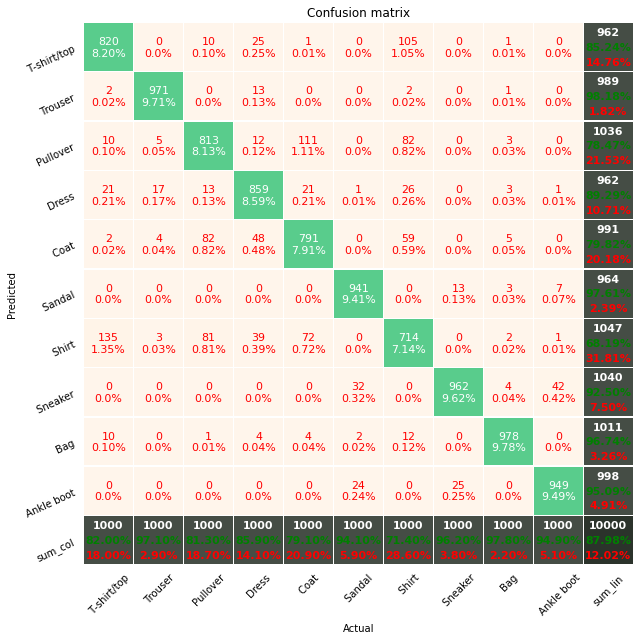

In [41]:


plt = plot_confusion_matrix_from_data(test_labels.reshape((-1,1)),pred,columns=class_names)
wandb.init(project='CS6910-Assignment1-3')
wandb.run.name = 'conf_matrix'
wandb.log({'conf_matrix':wandb.Image(plt), 'test_acc' : acc})
wandb.finish()

In [42]:
acc

0.8798